# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

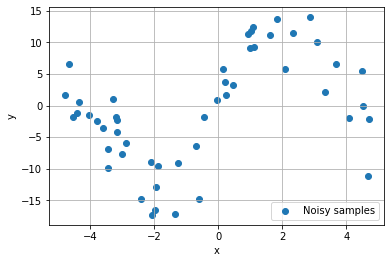

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

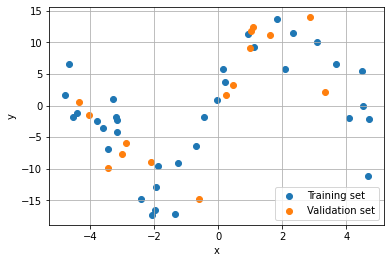

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=150000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=150000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=150000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=150000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

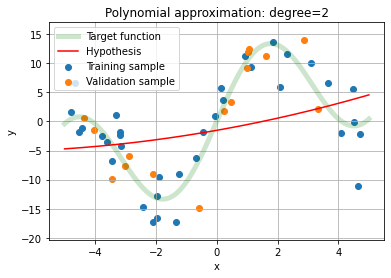

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

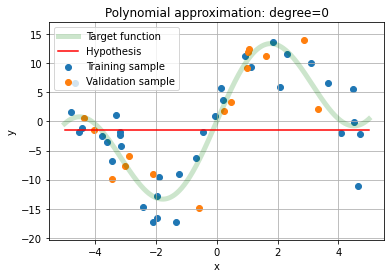

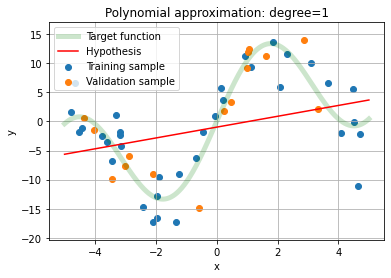

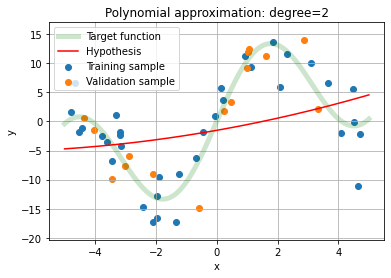

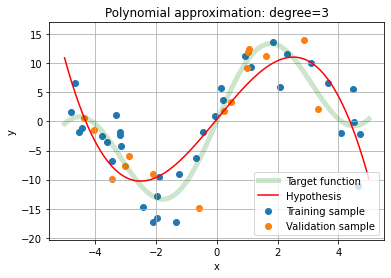

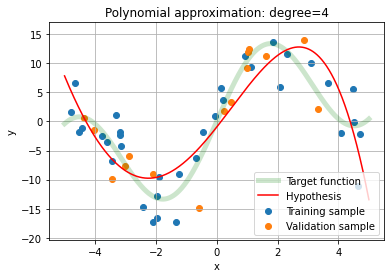

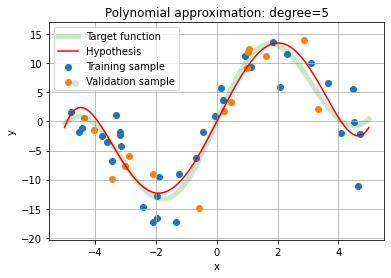

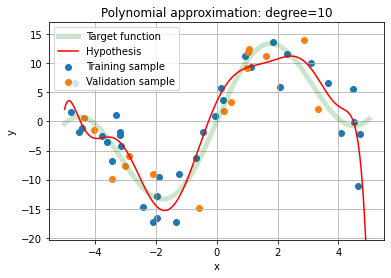

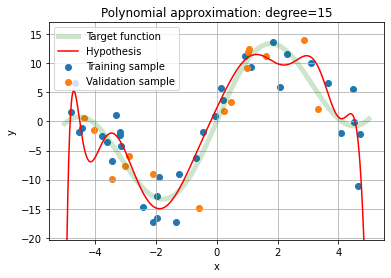

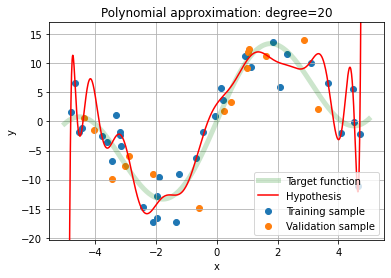

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

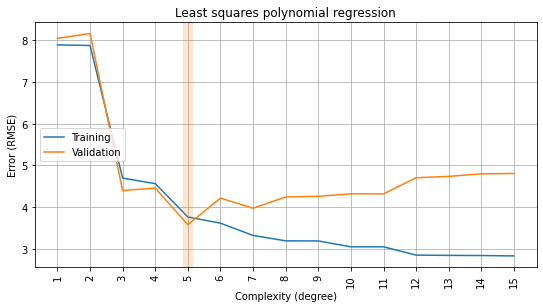

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph',ylim=None,xlim=None):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    if ylim:
        plt.ylim(*ylim)
    if xlim:
        plt.xlim(*xlim)
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES[1:]:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

4

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

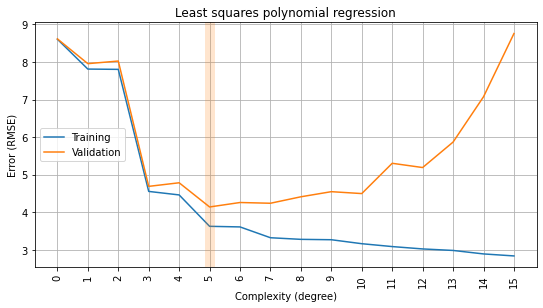

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

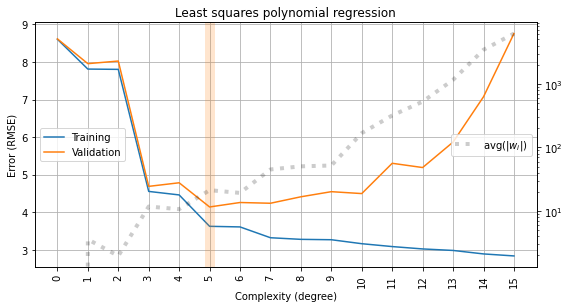

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

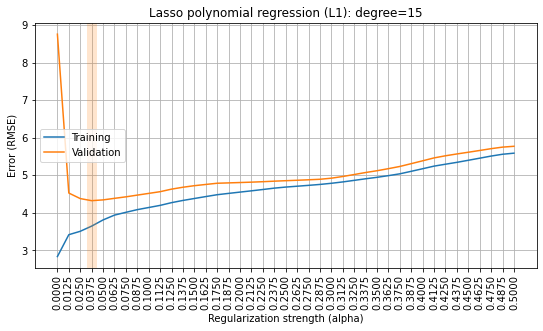

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

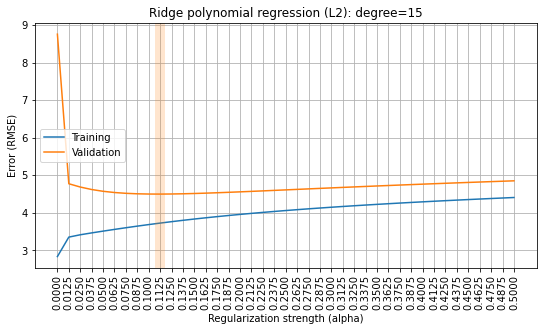

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
#finding most correlated features to polynomize
df = X_diabetes.copy()
df['target'] = y_diabetes
df.corr()['target'].sort_values(ascending=False)

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441484
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

I'll take `bmi`, `s5`, `bp`, `s4` for polynomisation.

In [22]:
def add_polynom_of_some_feat(degree, X, poly_feat):
    #getting polynims of some features
    X.reset_index(drop=True,inplace=True)
    X_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X[poly_feat])
    X_new = pd.DataFrame(X_poly)
    #collecting all features together
    other_feat = list(set(X.columns) - set(poly_feat))
    i = X_poly.shape[1]
    for feat in other_feat:
        X_new[i] = X[feat]
        i += 1
    return X_new


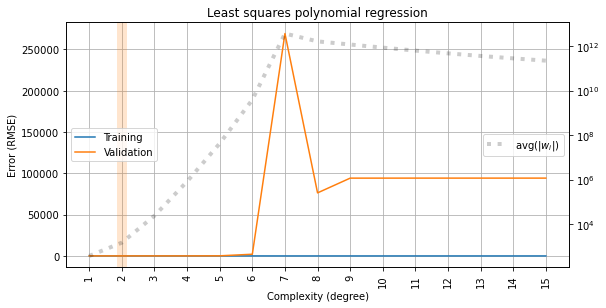

In [23]:
poly_feat = ['bmi','s5','bp','s4']
other_feat = list(set(X_diabetes.columns) - set(poly_feat))

rmse_train, rmse_valid, avg_coef = [], [], []
model = LinearRegression()
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

for degree in DEGREES[1:]:
    X_train_new = add_polynom_of_some_feat(degree, X_train, poly_feat)
    X_valid_new = add_polynom_of_some_feat(degree, X_valid, poly_feat)
    model.fit(X_train_new,y_train)
    rmse_train.append(rmse(model.predict(X_train_new), y_train))
    rmse_valid.append(rmse(model.predict(X_valid_new), y_valid))
    avg_coef.append(np.mean([np.mean(np.abs(model.coef_))]))
    
    
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

Here we can see that our model is well-fitted up to `degree = 7`.

At this point it becomes **extremely** overfitted.

At `degree` higher than 8 the diffrence of metrics is not as extreme, but still very much significant.

We can take a cloder look at the left part of our plot:

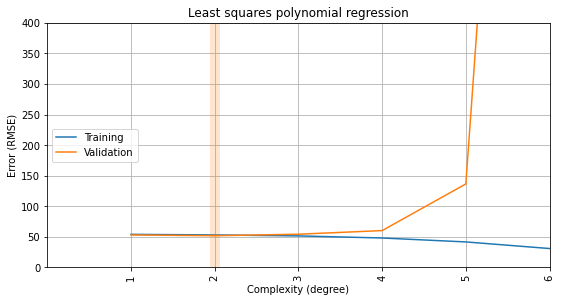

In [24]:
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   
                   title='Least squares polynomial regression', xlim=(0,6),ylim=(0,400))

After a closer look we can see that after `degree` = 3 metrics on valid set start going up, when metrics on train set gradually minimize.

`degree` = 2 seems to be the best choice.

For curiosity purposes, i tried polynomisation of all features, but to a lower degree.

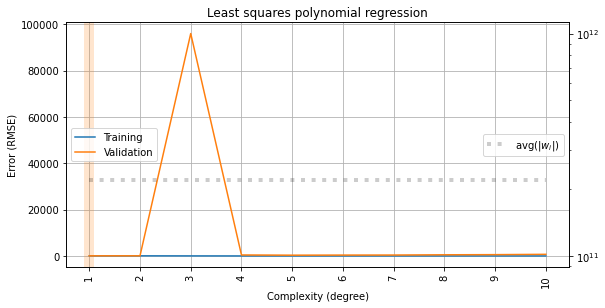

In [25]:
rmse_train, rmse_valid, avg_coef = [], [], []
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

for degree in DEGREES[1:11]:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef.append(np.mean([np.mean(np.abs(model.coef_))]))
    
plot_fitting_graph(DEGREES[1:11], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

We see that unusual spike at around `degree` = 3.

Let's experiment with partial polunomisation some more (you can run the next cell locally many times to see different plots)

Poly features: ['s6', 's3', 's5', 'age']


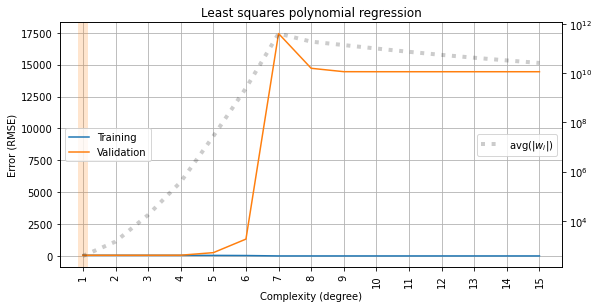

In [26]:
poly_feat = []
for i in range(5):
    rand_col = X_diabetes.columns[np.random.randint(X_diabetes.shape[1])]
    if rand_col not in poly_feat:
        poly_feat.append(rand_col)
        
print('Poly features: {}'.format(poly_feat))
    
other_feat = list(set(X_diabetes.columns) - set(poly_feat))

rmse_train, rmse_valid, avg_coef = [], [], []
model = LinearRegression()
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

for degree in DEGREES[1:]:
    X_train_new = add_polynom_of_some_feat(degree, X_train, poly_feat)
    X_valid_new = add_polynom_of_some_feat(degree, X_valid, poly_feat)
    model.fit(X_train_new,y_train)
    rmse_train.append(rmse(model.predict(X_train_new), y_train))
    rmse_valid.append(rmse(model.predict(X_valid_new), y_valid))
    avg_coef.append(np.mean([np.mean(np.abs(model.coef_))]))
    
    
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

A common pattern that I noticed after looking at many such plots is that at lower degrees errors are minimal, then the unusual spike of validation error metric happens, then it goes down a bit, but still stays *significantly* higher that training error metric at same degrees.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

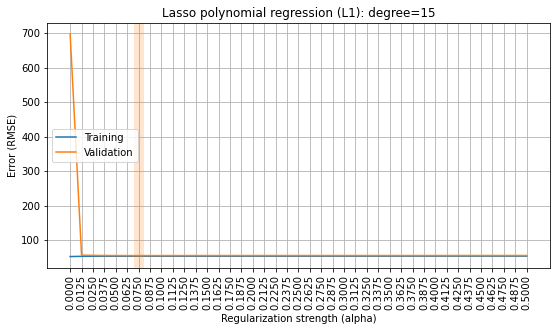

In [27]:
rmse_train, rmse_valid = [], []
poly_feat = ['bmi']
other_feat = list(set(X_diabetes.columns) - set(poly_feat))

X_new = add_polynom_of_some_feat(15, X_diabetes, poly_feat)

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_new, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')
L1_rmse_valid_min = np.array(rmse_valid).min()

I had to increase number of iterations in Lasso regularisation up to 150000 iteration. Also, it couldn't converge if I made a polynom of more than 1 feature.

But I did get a result, we can take a closer look at the plot.

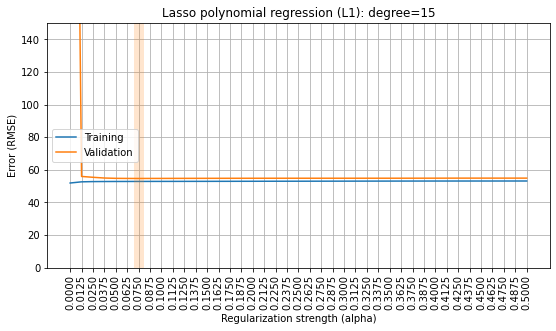

In [28]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15',ylim=(0,150))

With the help of Lasso regularization we managed to minimize error and weights in case when we use high-degree polynome features.

#### L2

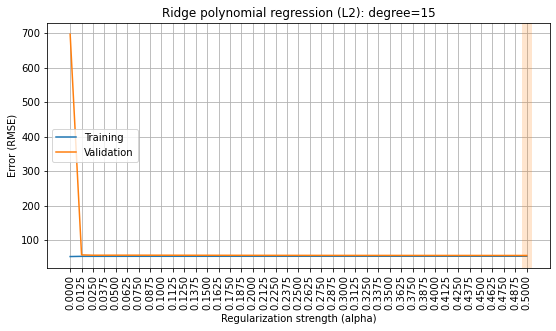

In [29]:
rmse_train, rmse_valid = [], []
poly_feat = ['bmi']
other_feat = list(set(X_diabetes.columns) - set(poly_feat))

X_new = add_polynom_of_some_feat(15, X_diabetes, poly_feat)

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha), 
                             X_new, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2): degree=15')
L2_rmse_valid_min = np.array(rmse_valid).min()

In [30]:
print('Minimal RMSE on validation set using Lasso: {}'.format(L1_rmse_valid_min))
print('Minimal RMSE on validation set using Ridge: {}'.format(L2_rmse_valid_min))

Minimal RMSE on validation set using Lasso: 54.70716998287975
Minimal RMSE on validation set using Ridge: 55.053822874737115


#### Summary

We can see that Lasso regularization got us lower error metric. Perhaps, Ridge also could to that if we played with some parameters od added iterations, but it's just my assumption.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [31]:
weights_L1 = []
poly_feat = ['bmi']
other_feat = list(set(X_diabetes.columns) - set(poly_feat))

X_new = add_polynom_of_some_feat(15, X_diabetes, poly_feat)
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_diabetes, test_size=0.3, random_state=SEED)

for alpha in ALPHAS[1:]:    
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train,y_train)
    weights_L1.append(model.coef_)
    
weights_L1 = np.array(weights_L1)    
weights_df_L1 = pd.DataFrame(data=weights_L1,index=ALPHAS[1:])
#calculate how many weights are equal to zero per iteration
weights_df_L1['zeros'] = np.isclose(weights_L1,0).sum(axis=1)

In [32]:
weights_df_L1.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,zeros
0.0125,526.183331,766.020705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-116.327143,93.061293,379.698603,-353.927480,455.207104,-246.685807,46.045628,39.885447,202.290159,13
0.0250,560.998315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-171.040113,0.000000,372.319049,-226.744206,407.099514,-236.107036,43.438746,22.178685,168.948691,15
0.0375,560.913297,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-197.885512,-0.000000,366.714620,-190.617740,402.460180,-224.528480,41.159508,15.264536,127.022492,15
0.0500,560.828747,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-224.725475,-0.000000,361.110626,-154.495406,397.820306,-212.950286,38.879913,8.350439,85.102769,15
0.0625,560.743762,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-251.570492,-0.000000,355.506227,-118.369230,393.180934,-201.371756,36.600650,1.436294,43.177025,15


In [33]:
weights_df_L1['zeros']

0.0125    13
0.0250    15
0.0375    15
0.0500    15
0.0625    15
0.0750    16
0.0875    17
0.1000    17
0.1125    17
0.1250    17
0.1375    17
0.1500    17
0.1625    17
0.1750    18
0.1875    18
0.2000    19
0.2125    19
0.2250    19
0.2375    19
0.2500    19
0.2625    19
0.2750    19
0.2875    19
0.3000    19
0.3125    19
0.3250    19
0.3375    19
0.3500    20
0.3625    20
0.3750    20
0.3875    20
0.4000    20
0.4125    20
0.4250    20
0.4375    20
0.4500    20
0.4625    20
0.4750    20
0.4875    20
0.5000    20
Name: zeros, dtype: int32

We can see that amount of zero weigths increases as `alpha` get higher.

Let's see which features stayed with non-zero weights.

In [34]:
zeros_per_weight = np.isclose(weights_L1,0).sum(axis=0)
non_zero_weights = np.isclose(zeros_per_weight,0)
non_zero_weights_idx = non_zero_weights.nonzero()
non_zero_weights_idx

(array([ 0, 15, 17, 19], dtype=int64),)

Features with indices 0, 16, 18, 22 stayed non-zero throughout regularization.

If we remember the way we formed partially polynomial features in this case, the first 15 features are our only `poly_feat` in degrees from 1 to 15, the other features where appended in order they appeared in `other_feat`. 

In [35]:
print('Features with non-zero weights are:')
for i in non_zero_weights_idx[0]:
    if i <= 14:
        print('{} in {}-th degree'.format(poly_feat[0],i+1))
    else:
        print('{}'.format(other_feat[i-15]))

Features with non-zero weights are:
bmi in 1-th degree
s3
bp
s5


If we revisit a list of features that correlate with target the most, we can see a clear connection, except for `s3` feature, that was chosen instead of `s4`.

In [36]:
df.corr()['target'].abs().sort_values(ascending=False)[:6]

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441484
s4        0.430453
s3        0.394789
Name: target, dtype: float64

Perhaps, that was due to high correlation between `s4` and `s3`,`s5`, while `s3` and `s5` don't correlate much.

In [37]:
print('s4 - s5: {}'.format(df['s4'].corr(df['s5'])))
print('s4 - s3: {}'.format(df['s4'].corr(df['s3'])))
print('s3 - s5: {}'.format(df['s3'].corr(df['s5'])))

s4 - s5: 0.617857391737446
s4 - s3: -0.7384927292583829
s3 - s5: -0.39857700450398387


#### L2

In [38]:
weights_L2 = []
poly_feat = ['bmi']
other_feat = list(set(X_diabetes.columns) - set(poly_feat))

X_new = add_polynom_of_some_feat(15, X_diabetes, poly_feat)
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_diabetes, test_size=0.3, random_state=SEED)

for alpha in ALPHAS[1:]:    
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train,y_train)
    weights_L2.append(model.coef_[0])
    
weights_df_L2 = pd.DataFrame(data=weights_L2,index=ALPHAS[1:])
weights_L2 = np.array(weights_L2) 
#calculate how many weights are equal to zero per iteration
weights_df_L2['zeros'] = np.isclose(weights_L2,0).sum(axis=1)

In [39]:
weights_df_L2.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,zeros
0.0125,533.764036,391.834688,37.927560,7.504537,0.935407,0.147933,0.020929,0.003232,0.000488,0.000076,...,-122.426970,95.422222,378.081136,-357.673708,448.279060,-251.856106,52.367894,40.634639,202.349649,1
0.0250,535.864092,222.207482,22.140828,4.165584,0.521066,0.081356,0.011490,0.001764,0.000266,0.000041,...,-169.757437,8.133663,371.338223,-242.629292,399.898299,-245.501068,57.457655,39.460082,185.925152,1
0.0375,532.171673,159.080036,16.332104,2.948511,0.370614,0.057258,0.008082,0.001235,0.000186,0.000029,...,-189.532573,-27.535084,365.591966,-191.329086,377.182628,-239.558949,61.733980,39.351302,177.269889,1
0.0500,526.938910,125.994894,13.290479,2.315598,0.292441,0.044762,0.006317,0.000962,0.000144,0.000022,...,-199.783660,-45.990894,360.312032,-161.729334,363.123704,-233.921865,65.538680,39.503478,171.653554,1
0.0625,521.168885,105.557313,11.407400,1.926440,0.244376,0.037092,0.005234,0.000794,0.000119,0.000018,...,-205.624129,-56.680269,355.342652,-142.120571,353.045316,-228.540179,68.992020,39.751015,167.590785,1


In [40]:
weights_df_L2['zeros']

0.0125    1
0.0250    1
0.0375    1
0.0500    1
0.0625    1
0.0750    2
0.0875    2
0.1000    2
0.1125    2
0.1250    2
0.1375    2
0.1500    2
0.1625    2
0.1750    2
0.1875    2
0.2000    2
0.2125    2
0.2250    2
0.2375    2
0.2500    2
0.2625    2
0.2750    2
0.2875    2
0.3000    2
0.3125    2
0.3250    2
0.3375    2
0.3500    2
0.3625    2
0.3750    2
0.3875    2
0.4000    2
0.4125    2
0.4250    2
0.4375    2
0.4500    2
0.4625    2
0.4750    2
0.4875    2
0.5000    2
Name: zeros, dtype: int32

We can see that with Ridge regularization many weiths are really small, but only 1-2 if them are close to 0.

#### Summary

I researched the way two regularization methods (Lasso and Ridge) minimize weights. 

I found out that Lasso regularization is *a lot* more likely to produce zero coefficients which might be helpful when performing feature selection.

Ridge regularization successfully minimizes weights and keeps coefficient very small, but not small enough to be considired equal to 0.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [41]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

<ipython-input-42-a076d5299058>:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train,y_train)
C:\Users\masha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\masha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290.2684640121117, tolerance: 0.1684880462633894
  model = cd_fast.enet_coordinate_descent(


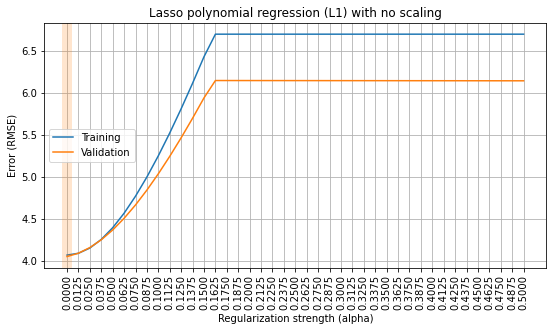

In [42]:
rmse_train, rmse_valid, scores_L1_unscaled = [], [], []

X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

for alpha in ALPHAS:    
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train,y_train)
    rmse_train.append(rmse(model.predict(X_train), y_train))
    rmse_valid.append(rmse(model.predict(X_valid), y_valid))
    scores_L1_unscaled.append(model.score(X_valid, y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1) with no scaling')

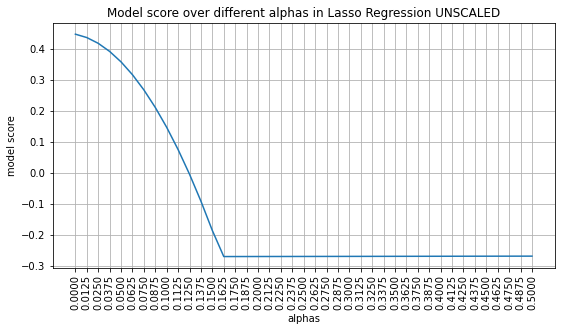

In [43]:
def plot_model_scores(scores,alphas,title):
    plt.figure(figsize=(9, 4.5))
    plt.plot(alphas, scores)
    plt.title(title)
    plt.xlabel('alphas')
    plt.ylabel('model score')
    plt.grid(True)
    plt.xticks(alphas, rotation='vertical')
    plt.show()
    
plot_model_scores(scores_L1_unscaled,ALPHAS,title='Model score over different alphas in Lasso Regression UNSCALED')

We see that our model score even gets negative.

What do model predictions look like in that case?

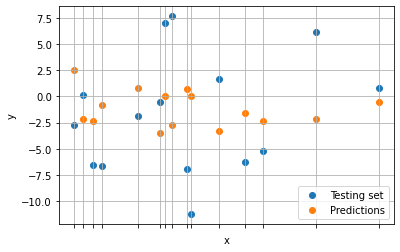

In [44]:
#I'll take a model with alpha = 0.1750 for example
model = Lasso(alpha=0.1750, random_state=SEED, max_iter=150000)
model.fit(X_train,y_train)

y_pred = model.predict(X_valid)
plt.xticks(X_valid[:,1], rotation='vertical', labels='')
plot_scatter(X_valid[:,1], y_valid, label='Testing set')
plot_scatter(X_valid[:,1], y_pred, label='Predictions')

We can see that our model's predictions are very dirrefent from expected.

### Now let's do some scaling

<ipython-input-45-e1a56ea82c98>:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train,y_train)
C:\Users\masha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\masha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.807499884321457, tolerance: 0.003951453559900716
  model = cd_fast.enet_coordinate_descent(


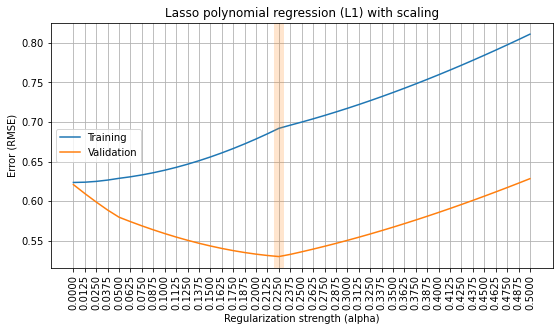

In [45]:
rmse_train, rmse_valid, scores_L1_scaled = [], [], []

scaler_x = StandardScaler()
X_hw_scaled = scaler_x.fit(X_hw)
X_hw_scaled = scaler_x.transform(X_hw)

scaler_y = StandardScaler()
y_hw = y_hw.reshape((-1,1))
y_hw_scaled = scaler_y.fit(y_hw)
y_hw_scaled = scaler_y.transform(y_hw)

X_train, X_valid, y_train, y_valid = train_test_split(X_hw_scaled, y_hw_scaled, test_size=0.3, random_state=SEED)

for alpha in ALPHAS:    
    model = Lasso(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train,y_train)
    rmse_train.append(rmse(model.predict(X_train), y_train))
    rmse_valid.append(rmse(model.predict(X_valid), y_valid))
    scores_L1_scaled.append(model.score(X_valid,y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1) with scaling')

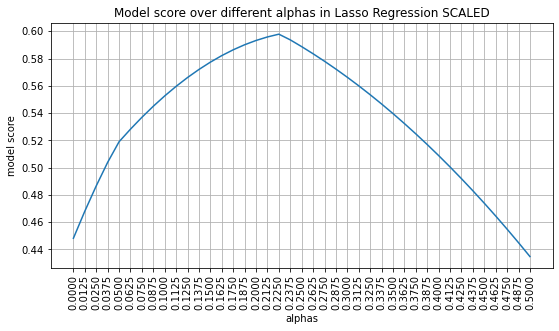

In [46]:
plot_model_scores(scores_L1_scaled,ALPHAS,title='Model score over different alphas in Lasso Regression SCALED')

First of all, after scaling our model score never went lower than 0.4.

Let's visualize the best prediction we got:

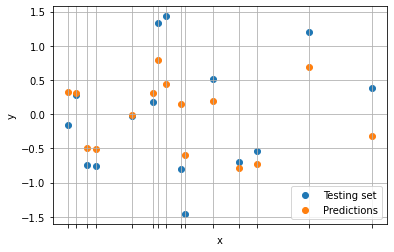

In [47]:
#I'll take a model with alpha = 0.2250 for example
model = Lasso(alpha=0.2250, random_state=SEED, max_iter=150000)
model.fit(X_train,y_train)
y_pred = model.predict(X_valid)
plt.xticks(X_valid[:,1], rotation='vertical', labels='')
plot_scatter(X_valid[:,1], y_valid, label='Testing set')
plot_scatter(X_valid[:,1], y_pred, label='Predictions')

We can see our model predictions are much better.

#### L2

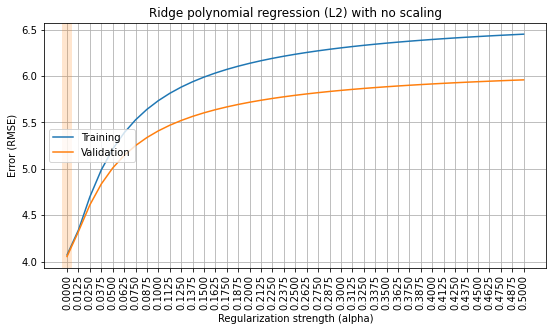

In [48]:
rmse_train, rmse_valid, scores_L2_unscaled = [], [], []

X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

for alpha in ALPHAS:    
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train,y_train)
    rmse_train.append(rmse(model.predict(X_train), y_train))
    rmse_valid.append(rmse(model.predict(X_valid), y_valid))
    scores_L2_unscaled.append(model.score(X_valid, y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2) with no scaling')

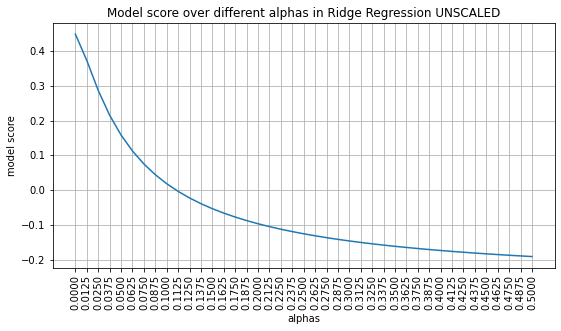

In [49]:
plot_model_scores(scores_L2_unscaled,ALPHAS,title='Model score over different alphas in Ridge Regression UNSCALED')

Score is getting worse as alpha rises.

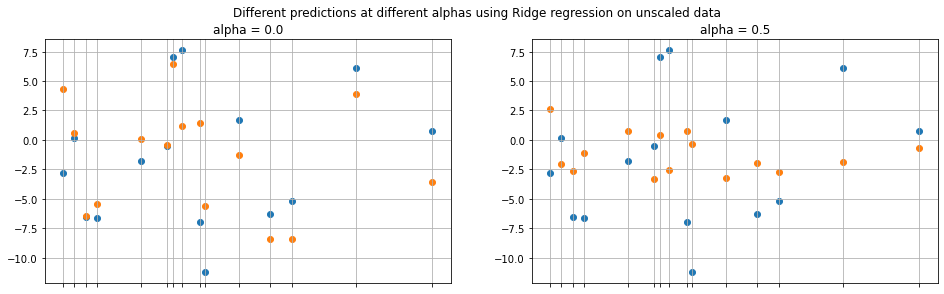

In [50]:
fig, ax = plt.subplots(1, 2)
fig.suptitle('Different predictions at different alphas using Ridge regression on unscaled data')
fig.set_size_inches(16,4.5)
alpha = 0.0

for i in [0,1]:
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_valid)
    ax[i].set_title(f'alpha = {alpha}')
    ax[i].scatter(X_valid[:,1], y_valid, label='Testing set')
    ax[i].scatter(X_valid[:,1], y_pred,label='Predictions')
    ax[i].set_xticks(X_valid[:,1],minor=False)
    ax[i].set_xticklabels(labels='',rotation="vertical")
    ax[i].grid(True)
    alpha = 0.5

The first prediction with `alpha = 0.0` is obviously better, but let's see if the score improves after scaling.

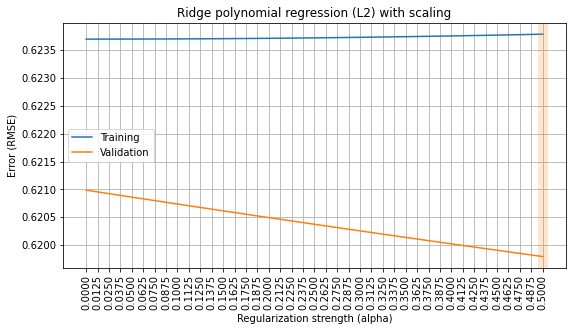

In [51]:
rmse_train, rmse_valid, scores_L2_scaled = [], [], []

scaler_x = StandardScaler()
X_hw_scaled = scaler_x.fit(X_hw)
X_hw_scaled = scaler_x.transform(X_hw)

scaler_y = StandardScaler()
y_hw = y_hw.reshape((-1,1))
y_hw_scaled = scaler_y.fit(y_hw)
y_hw_scaled = scaler_y.transform(y_hw)

X_train, X_valid, y_train, y_valid = train_test_split(X_hw_scaled, y_hw_scaled, test_size=0.3, random_state=SEED)

for alpha in ALPHAS:    
    model = Ridge(alpha=alpha, random_state=SEED, max_iter=150000)
    model.fit(X_train,y_train)
    rmse_train.append(rmse(model.predict(X_train), y_train))
    rmse_valid.append(rmse(model.predict(X_valid), y_valid))
    scores_L2_scaled.append(model.score(X_valid,y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2) with scaling')

Before scaling, the error metric would rise much faster and more significantly.

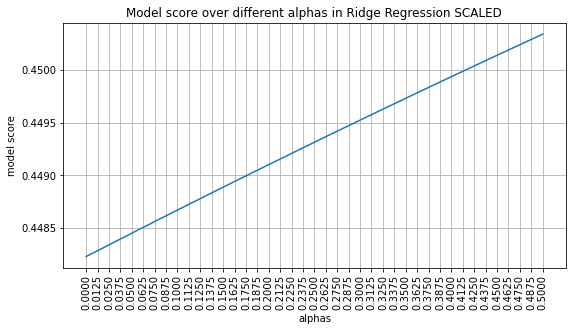

In [52]:
plot_model_scores(scores_L2_scaled,ALPHAS,title='Model score over different alphas in Ridge Regression SCALED')

Model score stayed pretty consistent throughout regularization with slight improvement from 0.4485 to 0.45+, never went negative.

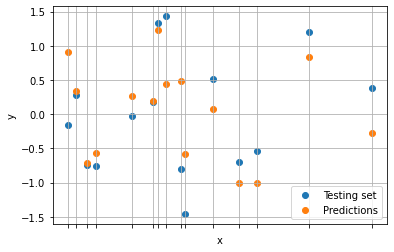

In [53]:
model = Ridge(alpha=0.5, random_state=SEED, max_iter=150000)
model.fit(X_train,y_train)

y_pred = model.predict(X_valid)
plt.xticks(X_valid[:,1], rotation='vertical', labels='')
plot_scatter(X_valid[:,1], y_valid, label='Testing set')
plot_scatter(X_valid[:,1], y_pred, label='Predictions')

Very similar to the best score we got without scaling.

### Summary



I compared the way Lasso and Ridge models behave when facing scaled and unscaled data.

General conclusion is that both regressors perform better if they work with scaled data. Unscaled data results in unreliable predictions, with model scores going as low as -0.2. That never happened with scaled data in both models, in fact, scaling improved model's performance regardless of `alpha` values. We could observe more significant model improvement in Lasso regilarisation, less so in Ridge regularisation.

#### Once again, all model scored together

Text(0.5, 1.0, 'Ridge scaled')

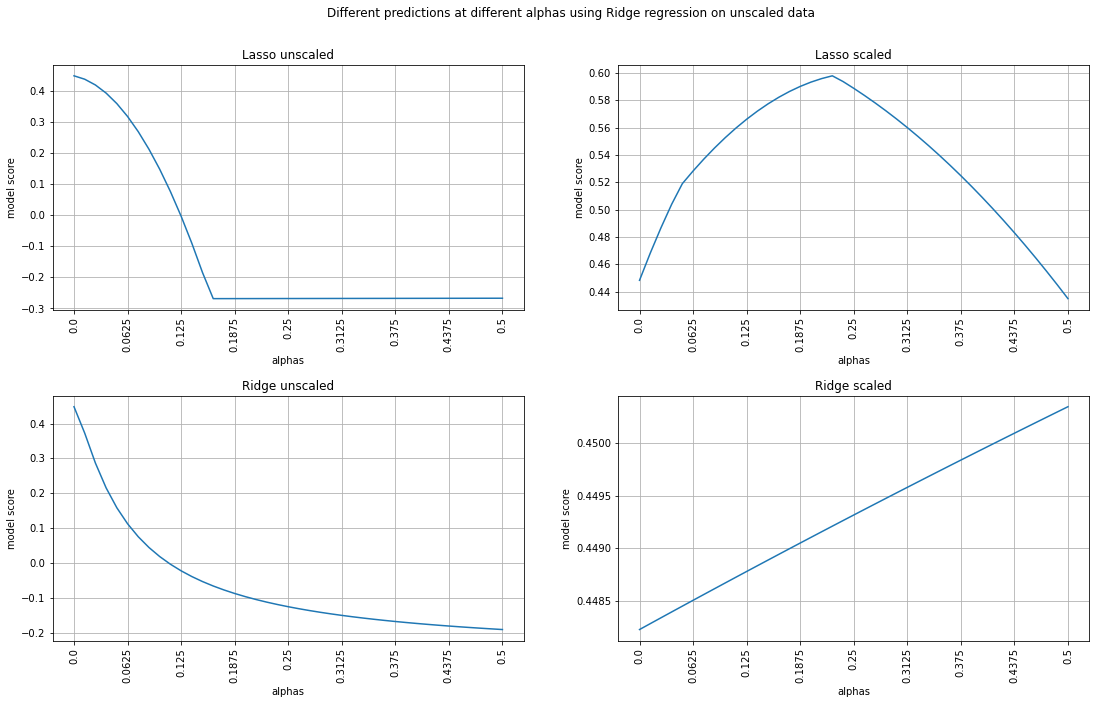

In [54]:
fig, ax = plt.subplots(2, 2)
fig.suptitle('Different predictions at different alphas using Ridge regression on unscaled data')
fig.set_size_inches(18,10)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('alphas')
        ax[i,j].set_ylabel('model score')
        ax[i,j].set_xticks(ALPHAS[::5],minor=False)
        ax[i,j].set_xticklabels(labels=ALPHAS[::5],rotation="vertical")
        ax[i,j].grid(True)

ax[0,0].plot(ALPHAS, scores_L1_unscaled)
ax[0,0].set_title('Lasso unscaled')
ax[0,1].plot(ALPHAS, scores_L1_scaled)
ax[0,1].set_title('Lasso scaled')
ax[1,0].plot(ALPHAS, scores_L2_unscaled)
ax[1,0].set_title('Ridge unscaled')
ax[1,1].plot(ALPHAS, scores_L2_scaled)
ax[1,1].set_title('Ridge scaled')